# Exploratory Data Analysis

In [1]:
# load and view a .npy file
import numpy as np
from matplotlib import pyplot as plt
import sys
# load the .npy file
initial_inputs = np.load("initial_inputs.npy")
initial_outputs = np.load("initial_outputs.npy")
# summarize shape
print(initial_inputs.shape)
print(initial_outputs.shape)

# create a dataframe from inputs and outputs
import pandas as pd
data = pd.DataFrame(initial_inputs, columns=[f'input_{i}' for i in range(initial_inputs.shape[1])])
data['output'] = initial_outputs
print(data.head())

(15, 3)
(15,)
    input_0   input_1   input_2    output
0  0.171525  0.343917  0.248737 -0.112122
1  0.242114  0.644074  0.272433 -0.087963
2  0.534906  0.398501  0.173389 -0.111415
3  0.492581  0.611593  0.340176 -0.034835
4  0.134622  0.219917  0.458206 -0.048008


## Observations
- Outputs are very small numbers.  Engineering intuition tells me that noise may impact these results signficantly

# Gaussian Process with Upper Confidence Bound Acquisition Function
1. Using the code from Module 12, I get rubbish numbers, but Copilot generated code seems to yeild a better mean, but throws an error re: convergence

In [8]:

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Define the search space for the next sample (grid in [0,1]^3)
grid_size = 20  # Smaller grid for 3D to avoid huge computation
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
x3 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b, c] for a in x1 for b in x2 for c in x3])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Upper Confidence Bound (UCB) acquisition function
kappa = 2.0  # Exploration-exploitation trade-off parameter
ucb = mean + kappa * std

# Select the next input sample as the point with the highest UCB
next_index = np.argmax(ucb)
next_sample = X_grid[next_index]

print("Next input sample based on Upper Confidence Bound (UCB):", next_sample)
print("Predicted mean:", mean[next_index])
print("Predicted std deviation:", std[next_index])
print("UCB value:", ucb[next_index])


Next input sample based on Upper Confidence Bound (UCB): [1. 0. 0.]
Predicted mean: -0.056970964578912243
Predicted std deviation: 0.09506112317865437
UCB value: 0.1331512817783965


/Users/brucediesel/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


/Users/brucediesel/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


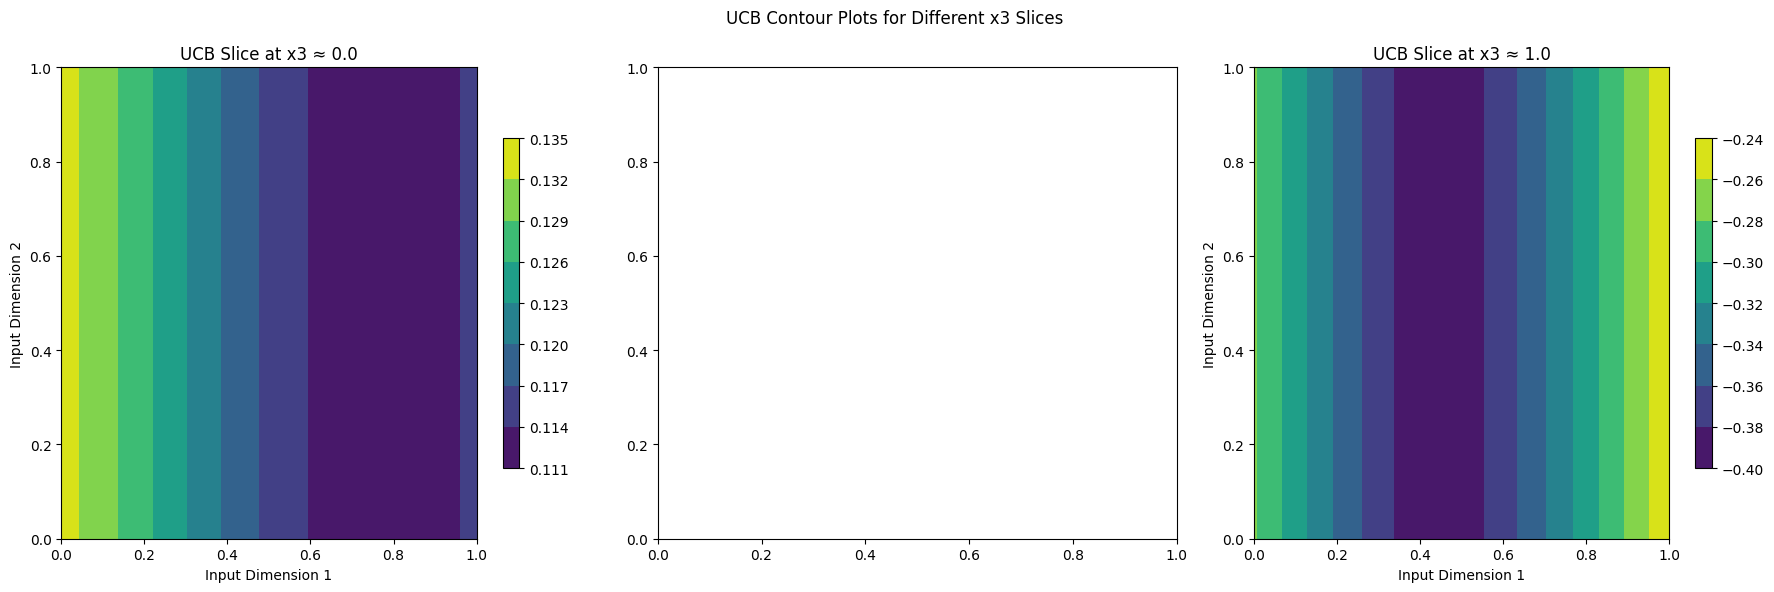

Next input sample based on UCB: [1.         1.         0.86206897]
Predicted mean: -0.03407305249353275
Predicted std deviation: 0.08412798290864688


In [10]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Define the search space for the next sample (grid in [0,1]^3)
grid_size = 30
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
x3 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b, c] for a in x1 for b in x2 for c in x3])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Compute UCB
kappa = 2.0
ucb = mean + kappa * std

# Select next point
next_index = np.argmax(ucb)
next_sample = X_grid[next_index]

# Visualise UCB slices for fixed x3 values
slice_values = [0.0, 0.5, 1.0]  # slices at these x3 values
fig, axes = plt.subplots(1, len(slice_values), figsize=(18, 6))

for idx, val in enumerate(slice_values):
    # Select points near the slice value
    tolerance = 0.02
    mask = np.abs(X_grid[:, 2] - val) < tolerance
    X_slice = X_grid[mask]
    ucb_slice = ucb[mask]

    # Reshape for contour plot
    if len(ucb_slice) == grid_size * grid_size:
        UCB_surface = ucb_slice.reshape(grid_size, grid_size)
        X1_mesh, X2_mesh = np.meshgrid(x1, x2)

        cs = axes[idx].contourf(X1_mesh, X2_mesh, UCB_surface, cmap='viridis')
        axes[idx].set_title(f'UCB Slice at x3 ≈ {val}')
        axes[idx].set_xlabel('Input Dimension 1')
        axes[idx].set_ylabel('Input Dimension 2')

        # Highlight next sample if in this slice
        if abs(next_sample[2] - val) < tolerance:
            axes[idx].scatter(next_sample[0], next_sample[1], color='red', marker='*', s=150, label='Next Sample')
            axes[idx].legend()

        fig.colorbar(cs, ax=axes[idx], shrink=0.7)

plt.suptitle('UCB Contour Plots for Different x3 Slices')
plt.tight_layout()
plt.show()

print("Next input sample based on UCB:", next_sample)
print("Predicted mean:", mean[next_index])
print("Predicted std deviation:", std[next_index])


# Gaussian Process with PI Acquisition Function
Using the xi value of 0.01

In [9]:

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Define the search space for the next sample (grid in [0,1]^3)
grid_size = 20  # Smaller grid for 3D to avoid huge computation
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
x3 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b, c] for a in x1 for b in x2 for c in x3])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Probability of Improvement (PI) acquisition function
best_y = np.max(y)  # For maximisation problem
xi = 0.01  # Small margin for improvement
z = (mean - best_y - xi) / std
pi = norm.cdf(z)

# Select the next input sample as the point with the highest PI
next_index = np.argmax(pi)
next_sample = X_grid[next_index]

print("Next input sample based on Probability of Improvement (PI):", next_sample)
print("Predicted mean:", mean[next_index])
print("Predicted std deviation:", std[next_index])
print("Probability of Improvement:", pi[next_index])



Next input sample based on Probability of Improvement (PI): [1.         0.78947368 0.36842105]
Predicted mean: -0.02122322948990056
Predicted std deviation: 0.02152760327466573
Probability of Improvement: 0.5666251577034901


/Users/brucediesel/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


# Gaussian Process with EI Acquisition Function

In [ ]:

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Define the search space for the next sample (grid in [0,1]^3)
grid_size = 20  # Smaller grid for 3D to avoid huge computation
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
x3 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b, c] for a in x1 for b in x2 for c in x3])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Expected Improvement (EI) acquisition function
best_y = np.max(y)  # For maximisation problem
xi = 0.01  # Small margin for improvement
z = (mean - best_y - xi) / std
ei = (mean - best_y - xi) * norm.cdf(z) + std * norm.pdf(z)

# Select the next input sample as the point with the highest EI
next_index = np.argmax(ei)
next_sample = X_grid[next_index]

print("Next input sample based on Expected Improvement (EI):", next_sample)
print("Predicted mean:", mean[next_index])
print("Predicted std deviation:", std[next_index])
print("Expected Improvement:", ei[next_index])


Next input sample based on Expected Improvement (EI): [1.         1.         0.42105263]
Predicted mean: -0.022527312999003984
Predicted std deviation: 0.06613579072944833
Expected Improvement: 0.027554427992335824


/Users/brucediesel/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


# Visualisation

# Week 1 Submission
0.999999-0.789473-0.368421